## VGG16

[DeepLearning100knock](https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/VGG_cifar10_pytorch.ipynb)を参考にVGG16を実装する。VGG16はシンプルに層を増やしたやつ。

In [17]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, out_dim, in_height = 32, in_width = 32):
        super(VGG16, self).__init__()
        
        self.in_height = in_height
        self.in_width = in_width
        
        class VGGBlock(nn.Module):
            def __init__(self, in_dim, dim, stride = 1, repeat = 3):
                super(VGGBlock, self).__init__()
            
                self.stride = stride
            
                module = []
            
                for i in range(repeat):
                    _in_dim = in_dim if i == 0 else dim
                    module.append(nn.Conv2d(_in_dim, dim, kernel_size = 3,
                                            padding = 1, stride = stride)) # width, heightは変わらない。
                    module.append(nn.BatchNorm2d(dim))
                    module.append(nn.ReLU())
                
                self.module = nn.Sequential(*module)
            
            def forward(self, x):
                return self.module(x)
        
        self.module = nn.Sequential(
            VGGBlock(in_dim = 3, dim = 64, stride = 1, repeat = 2),
            nn.MaxPool2d([2,2], padding = 1, stride = 2),
            VGGBlock(in_dim = 64, dim = 128, stride = 1, repeat = 2),
            nn.MaxPool2d([2,2], padding = 1, stride = 2),
            VGGBlock(in_dim = 128, dim = 256, stride = 1, repeat = 3),
            nn.MaxPool2d([2,2], padding = 1, stride = 3),
            VGGBlock(in_dim = 256, dim = 512, stride = 1, repeat = 3),
            nn.MaxPool2d([2,2], padding = 1, stride = 3),
            VGGBlock(in_dim = 512, dim = 512, stride = 1, repeat = 3),
            nn.MaxPool2d([2,2], padding = 1, stride = 3),
        
            # input: (-1, 3, in_height, in_height)
            # output: (-1, 512, (in_height + 160) // 108, (in_width + 160) // 108)
        )
    
        self.flatten = Flatten()
    
        self.top = nn.Sequential(
            nn.Linear(((self.in_height + 160) // 108) * ((self.in_width + 160) // 108) * 512, 4096), 
            # flattenしちゃったらバッチサイズに影響されそう？
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, out_dim)
        )
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = self.module(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.top(x)
        return x

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 32, 32

FOLD = 'StratifiedKFold' # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2

RANDOM_SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## データセットの準備

In [4]:
train_ds = torchvision.datasets.CIFAR10(root = './', train = True, download = True, transform = None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms = None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        
        if self.transforms:
            transformed = self.transforms(image = x)
            x = transformed['image']
            
        return x,y

Files already downloaded and verified


In [5]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0), ratio = (0.9,1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

In [28]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []
    
    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []
    
    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1} / {FOLD_N}")
        print(f"train_N = {len(train_idx)}, val_N={len(val_idx)}")
        
        #---
        # dataset
        #---
        
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]
        
        dataset_train = CifarDataset(X_train, y_train, transforms = transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms = transforms_val)
        
        dataloader_train = DataLoader(dataset_train, batch_size = 284, num_workers = 0,
                                      shuffle = True, pin_memory = True)
        dataloader_val = DataLoader(dataset_val, batch_size = 284, num_workers = 0,
                                    shuffle = False, pin_memory = True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        
        #---
        # model
        #---
        
        model = VGG16(out_dim = 10)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        
        #---
        # epoch
        #---
        
        for epoch in range(EPOCH):
            
            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()
                
                xs = batch[0].to(device)
                ys = batch[1].to(device)
                
                outputs = model(xs)
                loss = criterion(outputs, ys)
                loss = loss / train_n
                loss.backward()
                
                tr_loss += loss.item()
                
                _,predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()
                
                optimizer.step()
                
            train_losses.append(tr_loss)
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)
            
            train_time_end = time.time()
        
            
            #---
            # val
            #---
            
            model.eval()
            
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device)
                    ys = batch[1].to(device)
                    
                    outputs = model(xs)
                    
                    loss = criterion(outputs, ys)
                    
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())
                    
            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
            
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)
            
            print(f'fold:{fold_i + 1} epoch:{epoch + 1} / {EPOCH}[tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f} [val] loss:{val_loss:.4f} acc:{val_accuracy:.4f} [time] total: {total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec')
            
            # lr_scheduler.step()
            
            if (epoch + 1) % 100 == 0:
                savename = f'model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{fold_N}.pth'
                torch.save(model.state_dict(), savename)
                print(f'model saved to >> {savename}')
                
        #---
        # store last val loss and accuracy
        #---
        
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
        
        #---
        # save model
        #---
        
        savename = f'model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth'
        torch.save(model.state_dict(), savename)
        print(f'model saved to >> {savename}')
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker = '.', markersize = 6, color = 'red', label = 'train loss')
        ax1.plot(val_losses, marker = '.', markersize = 6, color = 'blue', label = 'val loss')
        ax2.plot(train_accuracies, marker = '.', markersize = 6, color = 'green', label = 'train accuracy')
        ax2.plot(val_accuracies, marker = '.', markersize = 6, color = 'orange', label = 'val accuracy')
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc = 'upper right')
        ax1.set(xlabel = 'Epoch', ylabel = 'Loss')
        ax2.set(ylabel = 'Accuracy')
        plt.show()
        
    #---
    # display fold score
    #---
    
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    print('all folds score')
    print(f'total loss: {val_cv_loss.mean():.6f}, accuracy: {val_cv_accuracy.mean():.6f}')
    for i in range(FOLD_N):
        print(f'fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy: {val_cv_accuracy[i]:.6f}')
        
    #---
    # label x pred
    #---
    
    res_df = pd.DataFrame({'label':val_cv_labels, 'pred':val_cv_preds})
    print()
    print('cross table')
    display(pd.crosstab(res_df['label'], res_df['pred']))
    
    return train_models, train_model_paths

StratifiedKFold fold:1 / 2
train_N = 25000, val_N=25000
fold:1 epoch:1 / 30[tra]loss:2.2725 acc:0.1460 [val] loss:2.1346 acc:0.2018 [time] total: 1922.08sec tra:1481.02sec val:441.06sec
fold:1 epoch:2 / 30[tra]loss:2.0512 acc:0.2058 [val] loss:2.1376 acc:0.1782 [time] total: 2085.08sec tra:1605.52sec val:479.56sec
fold:1 epoch:3 / 30[tra]loss:1.9970 acc:0.2306 [val] loss:1.9560 acc:0.2421 [time] total: 2250.24sec tra:1469.61sec val:780.63sec
fold:1 epoch:4 / 30[tra]loss:1.9323 acc:0.2520 [val] loss:1.8209 acc:0.2888 [time] total: 3159.80sec tra:2616.92sec val:542.88sec
fold:1 epoch:5 / 30[tra]loss:1.8992 acc:0.2582 [val] loss:1.8699 acc:0.2772 [time] total: 3179.98sec tra:2421.51sec val:758.47sec
fold:1 epoch:6 / 30[tra]loss:1.8596 acc:0.2778 [val] loss:1.8338 acc:0.2758 [time] total: 3618.89sec tra:3066.22sec val:552.67sec
fold:1 epoch:7 / 30[tra]loss:1.8321 acc:0.2948 [val] loss:1.6856 acc:0.3408 [time] total: 2438.64sec tra:1915.98sec val:522.65sec
fold:1 epoch:8 / 30[tra]loss:1.807

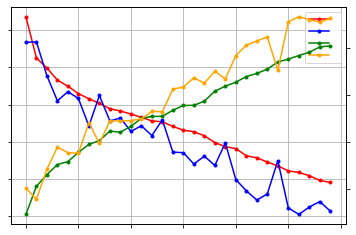

StratifiedKFold fold:2 / 2
train_N = 25000, val_N=25000
fold:2 epoch:1 / 30[tra]loss:2.3151 acc:0.1207 [val] loss:2.2102 acc:0.1468 [time] total: 1730.07sec tra:1373.55sec val:356.51sec
fold:2 epoch:2 / 30[tra]loss:2.0964 acc:0.1880 [val] loss:1.9740 acc:0.2092 [time] total: 1728.97sec tra:1366.59sec val:362.38sec
fold:2 epoch:3 / 30[tra]loss:2.0320 acc:0.2068 [val] loss:2.0180 acc:0.2012 [time] total: 1728.18sec tra:1371.08sec val:357.09sec
fold:2 epoch:4 / 30[tra]loss:1.9996 acc:0.2201 [val] loss:1.9225 acc:0.2432 [time] total: 1722.64sec tra:1366.38sec val:356.26sec
fold:2 epoch:5 / 30[tra]loss:1.9748 acc:0.2346 [val] loss:1.9391 acc:0.2401 [time] total: 1725.01sec tra:1366.76sec val:358.25sec
fold:2 epoch:6 / 30[tra]loss:1.9422 acc:0.2490 [val] loss:1.8789 acc:0.2729 [time] total: 1724.78sec tra:1367.88sec val:356.91sec
fold:2 epoch:7 / 30[tra]loss:1.8929 acc:0.2631 [val] loss:1.8780 acc:0.2694 [time] total: 1726.45sec tra:1369.62sec val:356.83sec
fold:2 epoch:8 / 30[tra]loss:1.862

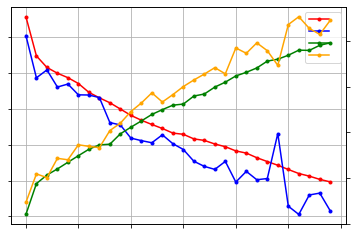

all folds score
total loss: 1.229657, accuracy: 0.553720
fold1/2 loss:1.228661, accuracy: 0.562520
fold2/2 loss:1.230654, accuracy: 0.544920

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2449,89,585,62,79,31,65,74,1458,108
1,105,2992,43,79,12,11,187,22,317,1232
2,439,61,1747,254,888,142,1066,179,198,26
3,58,51,320,1573,324,709,1463,191,234,77
4,88,2,419,120,2711,79,1245,253,70,13
5,41,69,175,1491,413,1683,632,247,172,77
6,19,26,102,170,130,14,4472,11,44,12
7,71,26,261,306,1162,260,344,2381,128,61
8,226,94,101,118,18,9,123,15,4200,96


In [29]:
train_models, train_model_paths = train()

In [ ]:
def test(train_models):
    for model in train_models:
        model.eval()
        
    model_num = len(train_models)
    
    test_ds = torchvision.datasets.CIFAR10(root = './', train = False, download = True, transform = None)
    
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)
    
    dataset_test = CifarDataset(test_Xs, test_ys, transforms = transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size = 512, num_workers = 4, shuffle = False, pin_memory = True)
    
    preds = []
    correct = 0
    
    with torch.no_grad():
        for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device)
            ys = batch[1]
            
            _preds = np.zeros([len(ys), 10])
            
            for model in train_models:
                # ?????????
                model_preds = F.softmax(model(Xs), dim = 1).detach().cpu().numpy()
                _preds += model_preds / model_num
                
            _preds = _preds.argmax(axis = 1)
            
            preds.extend(_preds)
            
            correct += sum(ys.numpy() == _preds)
            
    #---
    # label x pred
    #---
    
    res_df = pd.DataDrame({'label': test_ys, 'pred': preds})
    print()
    print('cross table')
    cross = pd.crosstab(res_df['label'], res_df['pred'])
    
    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")
    display(cross)
    
test(train_models)